# NeMo SD + ASR - Quartznet ami mixheadset DER 65.7%

In [1]:
# """
# You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
# TitaNet: https://arxiv.org/pdf/2110.04410.pdf

# Instructions for setting up Colab are as follows:
# https://colab.research.google.com/drive/1ZoALe4Vy4ekR3eedVwyyt1zF8ZjPZ2JU#scrollTo=sDtW2e8u634q
# 1. Open a new Python 3 notebook.
# 2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
# 3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
# 4. Run this cell to set up dependencies.
# """
# # If you're using Google Colab and not running locally, run this cell.

# ## Install dependencies
# !pip install wget
# !apt-get install sox libsndfile1 ffmpeg
# !pip install unidecode

# # ## Install NeMo
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

# ## Install TorchAudio
# !pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
# # !pip install torch==1.11.0 torchaudio==0.11.0 torchvision==0.12.0

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES

3


In [ ]:
import os
import glob
import subprocess
import tarfile
import wget
import copy
import pandas as pd
import numpy as np
import IPython
from IPython.display import Audio, display
import matplotlib.pyplot as plt

import spyder
import torchaudio
from collections import Counter
from omegaconf import OmegaConf

from pyannote.metrics.diarization import DiarizationErrorRate
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object
from nemo.collections.asr.models import ClusteringDiarizer
from nemo.collections.asr.parts.utils.decoder_timestamps_utils import ASR_TIMESTAMPS
from nemo.collections.asr.parts.utils.diarization_utils import ASR_DIAR_OFFLINE




In [ ]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data/ami_mix_headset')
os.makedirs(data_dir, exist_ok=True)
print("ROOT: ", ROOT)
print("Data Directory: ", data_dir)
      
audio_filepath = '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/'
groundtruth_rttm_filepath = os.path.join(data_dir, 'rttms')
print(groundtruth_rttm_filepath)
# has a train,dev,test subdir

if not os.path.exists(audio_filepath):
    print("Please give correct audio location. No ", audio_filepath)
if not os.path.exists(groundtruth_rttm_filepath):
    print("Please give correct rttm groundtruth location. No ", groundtruth_rttm_filepath)

    
test_type = 'test'
groundtruth_rttm_list = []
if test_type == 'test':
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        print(test_path)

!find {audio_filepath} -iname "*.wav" > data/ami_mix_headset/train_all.txt
# !cat {data_dir}/ami_headset/train_all.txt
# DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}


audio_list = []
with open(data_dir+'/train_all.txt') as data:
    audio_list.append(data.read().split())
audio_list = audio_list[0]
audio_list

In [5]:

def create_input_manifest(
    audio_filepath,
    rttm_filepath,
    offset=0,
    duration=None,
    label='infer',
    text='-',
    num_speakers=None,
    uem_filepath=None,
    manifest_filepath='/data/input_manifest.json' 
):
    # Create a manifest for input with below format. 
    # {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 
    # 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
    # if you would like to evaluate with known number of speakers pass the value else None. 
    # If you would like to score the system with known rttms then that should be passed as well, else None
    
    import json
    meta = {
        'audio_filepath': audio_filepath, 
        'offset': 0, 
        'duration':None, 
        'label': 'infer', 
        'text': '-', 
        'num_speakers': num_speakers, 
        'rttm_filepath': rttm_filepath, 
        'uem_filepath' : None
    }
    with open(manifest_filepath,'w') as fp:
        json.dump(meta,fp)
        fp.write('\n')

#     dataframe = pd.DataFrame.from_dict(meta, orient='index')
#     print("Manifest: ", meta)

    
def convert_ami_base():
    # Eg: TS3003a.rttm -> TS3003a.Mix-Headset.rttm
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        new_test_path = test_path[:-5]+".Mix-Headset.rttm"
        !mv {test_path} {new_test_path}
        print("new ", new_test_path)
        

def correct_sample_rate(audio_path, show_display=False):
    """
    Corrects the sample rate and channels of audio.
    Display shows audio file but takes time to load
    
    SAMPLE_RATE = 16000
    """
    SAMPLE_RATE = 16000
    waveform, sr = torchaudio.load(audio_path)
    metadata = torchaudio.info(audio_path)

    print(metadata)

    waveform = waveform.mean(dim=0) # if there are multiple channels, average them to single channel
    waveform = waveform.reshape(1, waveform.shape[0])
    if sr != SAMPLE_RATE:
        resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
        waveform_resampled = resampler(waveform)
        waveform = waveform_resampled

    torchaudio.save(audio_path, waveform, SAMPLE_RATE, bits_per_sample=16, encoding="PCM_S")

    metadata = torchaudio.info(audio_path)
    if show_display:
        # TODO: display_waveform(signal)
        print(f"SR: {SAMPLE_RATE}Hz, {waveform}")
        print("Metadata: ", metadata)
        display(Audio(audio_path,rate=SAMPLE_RATE, autoplay=True))


        
## RUN ONLY ONCE! Convert rttm to same AMI base name
# convert_ami_base()

## Display audio only for visualisation
correct_sample_rate(ROOT+'/data/an4_diarize_test.wav', show_display=False)

AudioMetaData(sample_rate=16000, num_frames=16789675, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [6]:
# single inialisation of manifests and dirs
scripts_dir = os.path.join(ROOT, 'scripts/speaker_tasks')
manifest_filepath = os.path.join(data_dir, 'input_manifest.json')

# config file
MODEL_CONFIG = os.path.join(data_dir,'offline_diarization_with_asr.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/offline_diarization_with_asr.yaml"
    MODEL_CONFIG = wget.download(config_url, data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))


metric = DiarizationErrorRate(collar=0.05)
ami_labels = []

for single_rttm in groundtruth_rttm_list:
    ami_label = single_rttm.split(sep="/")[-1]
    ami_label = ami_label[:-5] # remove .rttm from last
    ami_labels.append(ami_label)
    labels = rttm_to_labels(single_rttm)
    groundtruth = labels_to_pyannote_object(labels)
    num_speakers = Counter([l.split()[-1] for l in labels]).keys().__len__()

    # find the corresponding audio file according to rttm
    single_audio = [audio for audio in audio_list if ami_label in audio][0]
    
    ## -----Visualise data-----
    print("ami_label: ", ami_label)    
    # !cat {single_rttm} # view the sample groundtruth rttm file
    # print("labels: "labels, groundtruth)
    # print("num_speakers: ", num_speakers)   
    # print("single_audio: ", single_audio)

    # 1)-----Create input manifest and configs-----
    create_input_manifest(audio_filepath=single_audio, rttm_filepath=single_rttm, num_speakers=num_speakers, manifest_filepath=manifest_filepath)
 
    # Change configurations:
    pretrained_speaker_model='titanet_large'
    config.diarizer.manifest_filepath = manifest_filepath
    config.diarizer.out_dir = data_dir # Directory to store intermediate files and prediction outputs
    config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
    config.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
    config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
    config.diarizer.clustering.parameters.oracle_num_speakers=True
    # Using VAD generated from ASR timestamps
    config.diarizer.asr.model_path = 'QuartzNet15x5Base-En'
    config.diarizer.oracle_vad = False # ----> Not using oracle VAD 
    config.diarizer.asr.parameters.asr_based_vad = True
    config.diarizer.asr.parameters.threshold=100 # ASR based VAD threshold: If 100, all silences under 1 sec are ignored.
    config.diarizer.asr.parameters.decoder_delay_in_sec=0.2 # Decoder delay is compensated for 0.2 sec
    
    # 2) ------ASR timestamps-----
    asr_ts_decoder = ASR_TIMESTAMPS(**config.diarizer)
    asr_model = asr_ts_decoder.set_asr_model()
    word_hyp, word_ts_hyp = asr_ts_decoder.run_ASR(asr_model)

    ## debug info
    ## contains the sequence of words.
    # print("Decoded word output dictionary: \n", word_hyp[ami_label])
    ## contains frame level index of the start and the end of each word
    # print("Word-level timestamps dictionary: \n", word_ts_hyp[ami_label])
    
    
    # 3)-----Load model and diarize-----
    asr_diar_offline = ASR_DIAR_OFFLINE(**config.diarizer)
    asr_diar_offline.word_ts_anchor_offset = asr_ts_decoder.word_ts_anchor_offset
    diar_hyp, diar_score = asr_diar_offline.run_diarization(config, word_ts_hyp)
#     print("Diarization hypothesis output: \n", diar_hyp[ami_label])
    print("\n\nDiar score: ", diar_score)
    
#     # 4)-----Accumulate DER-----
    pred_labels = rttm_to_labels(data_dir+'/pred_rttms/'+ami_label+'.rttm')
    hypothesis = labels_to_pyannote_object(pred_labels)
    der = metric(groundtruth, hypothesis)
    print(f"Diarization error rate (DER) = {100 * der:.1f}%\n\n")


    


name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: null
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: ???
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: false
  clustering:
    parameters:
      oracle_num_speakers: false
      max_num_speakers: 20
      enhanced_count_thres: 80
      max_rp_threshold: 0.25
      sparse_search_volume: 30
      maj_vote_spk_count: false
  asr:
    model_path: ???
    parameters:
      asr_based_vad: false
   

[NeMo W 2022-07-25 09:48:57 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (WER). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-07-25 09:49:12 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


[NeMo W 2022-07-25 09:49:12 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (WER_TS). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:49:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:49:16 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:49:16 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:49:16 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:49:16 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:50:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:50:27 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:50:27 features:200] PADDING: 16
[NeMo I 2022-07-25 09:50:28 label_models:100] loss is Angular Softmax


[NeMo W 2022-07-25 09:50:28 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-07-25 09:50:28 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:50:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:50:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:50:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:50:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:50:28 collections:293] # 3035 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:07<00:00,  7.75s/it]
[NeMo W 2022-07-25 09:50:40 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
      warnings.warn(
    


[NeMo I 2022-07-25 09:50:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1379	 MISS 0.2228	                 Diarization ER: 0.5403	, Confusion ER:0.1796
[NeMo I 2022-07-25 09:50:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f11c2cdcfa0>, {'EN2002a.Mix-Headset': {'speaker_0': 'MEE071', 'speaker_1': 'FEO072', 'speaker_2': 'FEO070', 'speaker_3': 'MEE073'}})
Diarization error rate (DER) = 61.0%


ami_label:  EN2002b.Mix-Headset
[NeMo I 2022-07-25 09:51:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:51:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:51:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:51:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:51:04 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:51:04 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:51:04 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:51:04 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:51:05 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:51:05 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:51:05 features:200] PADDING: 16
[NeMo I 2022-07-25 09:51:05 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:51:06 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:51:06 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:51:06 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:51:06 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:51:06 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:51:06 collections:293] # 2488 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


[NeMo I 2022-07-25 09:51:17 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.2494	 MISS 0.2097	                 Diarization ER: 0.5905	, Confusion ER:0.1314
[NeMo I 2022-07-25 09:51:17 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f119083ceb0>, {'EN2002b.Mix-Headset': {'speaker_0': 'FEO070', 'speaker_1': 'FEO072', 'speaker_2': 'MEE073', 'speaker_3': 'MEE071'}})
Diarization error rate (DER) = 63.4%


ami_label:  EN2002c.Mix-Headset
[NeMo I 2022-07-25 09:51:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:51:25 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:51:25 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:52:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:52:29 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:52:29 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:52:29 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:52:29 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:52:30 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:52:30 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:52:30 features:200] PADDING: 16
[NeMo I 2022-07-25 09:52:31 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:52:31 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:52:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:52:31 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:52:31 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:52:31 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:52:31 collections:293] # 4341 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


[NeMo I 2022-07-25 09:52:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1583	 MISS 0.2189	                 Diarization ER: 0.4153	, Confusion ER:0.0381
[NeMo I 2022-07-25 09:52:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f11ff91bcd0>, {'EN2002c.Mix-Headset': {'speaker_0': 'FEO072', 'speaker_1': 'MEE071', 'speaker_2': 'MEE073'}})
Diarization error rate (DER) = 50.1%


ami_label:  EN2002d.Mix-Headset
[NeMo I 2022-07-25 09:53:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:53:11 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:53:11 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb1

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:54:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:54:19 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:54:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:54:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:54:19 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:54:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:54:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:54:19 features:200] PADDING: 16
[NeMo I 2022-07-25 09:54:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:54:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:54:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:54:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:54:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:54:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:54:20 collections:293] # 2995 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


[NeMo I 2022-07-25 09:54:31 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1553	 MISS 0.2002	                 Diarization ER: 0.4730	, Confusion ER:0.1175
[NeMo I 2022-07-25 09:54:31 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f11904abb20>, {'EN2002d.Mix-Headset': {'speaker_0': 'MEE073', 'speaker_1': 'MEE071', 'speaker_2': 'FEO072', 'speaker_3': 'FEO070'}})
Diarization error rate (DER) = 58.2%


ami_label:  ES2004a.Mix-Headset
[NeMo I 2022-07-25 09:54:44 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:54:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:54:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:54:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:54:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:54:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:54:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:54:46 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:54:47 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:54:47 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:54:47 features:200] PADDING: 16
[NeMo I 2022-07-25 09:54:48 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:54:48 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:54:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:54:48 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:54:48 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:54:48 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:54:48 collections:293] # 1518 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


[NeMo I 2022-07-25 09:54:52 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.3726	 MISS 0.2159	                 Diarization ER: 0.7178	, Confusion ER:0.1293
[NeMo I 2022-07-25 09:54:52 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f128c51ba30>, {'ES2004a.Mix-Headset': {'speaker_0': 'FEE016', 'speaker_1': 'MEO015', 'speaker_2': 'MEE014', 'speaker_3': 'FEE013'}})
Diarization error rate (DER) = 70.1%


ami_label:  ES2004b.Mix-Headset
[NeMo I 2022-07-25 09:54:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:54:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:54:56 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:54:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:54:59 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:54:59 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:54:59 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:54:59 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:55:00 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:55:00 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:55:00 features:200] PADDING: 16
[NeMo I 2022-07-25 09:55:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:55:01 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:55:01 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:55:01 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:55:01 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:55:01 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:55:01 collections:293] # 3651 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


[NeMo I 2022-07-25 09:55:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1551	 MISS 0.2528	                 Diarization ER: 0.6624	, Confusion ER:0.2545
[NeMo I 2022-07-25 09:55:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f128c0516a0>, {'ES2004b.Mix-Headset': {'speaker_0': 'FEE016', 'speaker_1': 'FEE013', 'speaker_2': 'MEE014', 'speaker_3': 'MEO015'}})
Diarization error rate (DER) = 66.9%


ami_label:  ES2004c.Mix-Headset
[NeMo I 2022-07-25 09:55:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:55:29 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:55:29 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:55:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:55:33 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:55:33 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:55:33 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:55:33 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:55:34 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:55:34 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:55:34 features:200] PADDING: 16
[NeMo I 2022-07-25 09:55:34 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:55:34 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:55:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:55:34 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:55:34 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:55:34 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:55:34 collections:293] # 3729 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


[NeMo I 2022-07-25 09:55:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1434	 MISS 0.2597	                 Diarization ER: 0.6047	, Confusion ER:0.2016
[NeMo I 2022-07-25 09:55:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f1190729f70>, {'ES2004c.Mix-Headset': {'speaker_0': 'MEE014', 'speaker_1': 'FEE013', 'speaker_2': 'FEE016', 'speaker_3': 'MEO015'}})
Diarization error rate (DER) = 62.7%


ami_label:  ES2004d.Mix-Headset
[NeMo I 2022-07-25 09:56:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:56:04 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:56:04 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:56:08 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:56:08 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:56:08 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:56:08 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:56:08 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:56:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:56:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:56:09 features:200] PADDING: 16
[NeMo I 2022-07-25 09:56:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:56:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:56:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:56:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:56:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:56:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:56:10 collections:293] # 3347 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


[NeMo I 2022-07-25 09:56:23 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.3115	 MISS 0.2246	                 Diarization ER: 0.8364	, Confusion ER:0.3003
[NeMo I 2022-07-25 09:56:23 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f11906fd670>, {'ES2004d.Mix-Headset': {'speaker_0': 'MEE014', 'speaker_1': 'FEE016', 'speaker_2': 'MEO015', 'speaker_3': 'FEE013'}})
Diarization error rate (DER) = 81.3%


ami_label:  IS1009a.Mix-Headset
[NeMo I 2022-07-25 09:56:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:56:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:56:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:56:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:56:41 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:56:41 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:56:41 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:56:41 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:56:42 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:56:42 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:56:42 features:200] PADDING: 16
[NeMo I 2022-07-25 09:56:42 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:56:42 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:56:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:56:42 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:56:42 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:56:42 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:56:42 collections:293] # 1240 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


[NeMo I 2022-07-25 09:56:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.3787	 MISS 0.2669	                 Diarization ER: 0.7818	, Confusion ER:0.1363
[NeMo I 2022-07-25 09:56:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f12ea3f1250>, {'IS1009a.Mix-Headset': {'speaker_0': 'FIE088', 'speaker_1': 'FIO089', 'speaker_2': 'FIO084', 'speaker_3': 'FIO087'}})
Diarization error rate (DER) = 75.9%


ami_label:  IS1009b.Mix-Headset
[NeMo I 2022-07-25 09:56:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:56:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:56:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:57:52 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:57:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:57:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:57:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:57:52 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:57:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:57:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:57:53 features:200] PADDING: 16
[NeMo I 2022-07-25 09:57:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:57:53 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:57:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:57:53 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:57:53 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:57:53 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:57:53 collections:293] # 3535 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


[NeMo I 2022-07-25 09:58:07 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1280	 MISS 0.3102	                 Diarization ER: 0.5170	, Confusion ER:0.0787
[NeMo I 2022-07-25 09:58:07 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f11980641c0>, {'IS1009b.Mix-Headset': {'speaker_0': 'FIO084', 'speaker_1': 'FIO087', 'speaker_2': 'FIO089', 'speaker_3': 'FIE088'}})
Diarization error rate (DER) = 55.8%


ami_label:  IS1009c.Mix-Headset
[NeMo I 2022-07-25 09:58:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:58:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:58:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:58:23 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:58:23 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:58:23 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:58:23 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:58:23 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:58:24 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:58:24 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:58:24 features:200] PADDING: 16
[NeMo I 2022-07-25 09:58:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:58:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:58:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:58:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:58:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:58:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:58:25 collections:293] # 2976 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


[NeMo I 2022-07-25 09:58:37 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1653	 MISS 0.2970	                 Diarization ER: 0.6576	, Confusion ER:0.1953
[NeMo I 2022-07-25 09:58:37 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f1198094130>, {'IS1009c.Mix-Headset': {'speaker_0': 'FIO089', 'speaker_1': 'FIE088', 'speaker_2': 'FIO087', 'speaker_3': 'FIO084'}})
Diarization error rate (DER) = 68.3%


ami_label:  IS1009d.Mix-Headset
[NeMo I 2022-07-25 09:58:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:58:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:58:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:58:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:58:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:58:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:58:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:58:49 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:58:50 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:58:50 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:58:50 features:200] PADDING: 16
[NeMo I 2022-07-25 09:58:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:58:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:58:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:58:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:58:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:58:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:58:50 collections:293] # 3005 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


[NeMo I 2022-07-25 09:59:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.2176	 MISS 0.2834	                 Diarization ER: 0.6193	, Confusion ER:0.1183
[NeMo I 2022-07-25 09:59:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f11903bbc10>, {'IS1009d.Mix-Headset': {'speaker_0': 'FIO089', 'speaker_1': 'FIE088', 'speaker_2': 'FIO084', 'speaker_3': 'FIO087'}})
Diarization error rate (DER) = 64.3%


ami_label:  TS3003a.Mix-Headset
[NeMo I 2022-07-25 09:59:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:59:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:59:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:59:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:59:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:59:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:59:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:59:15 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:59:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:59:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:59:16 features:200] PADDING: 16
[NeMo I 2022-07-25 09:59:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:59:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:59:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:59:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:59:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:59:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:59:17 collections:293] # 2013 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


[NeMo I 2022-07-25 09:59:23 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.5300	 MISS 0.2544	                 Diarization ER: 0.9165	, Confusion ER:0.1322
[NeMo I 2022-07-25 09:59:23 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f128e9db3d0>, {'TS3003a.Mix-Headset': {'speaker_0': 'MTD012ME', 'speaker_1': 'MTD009PM', 'speaker_2': 'MTD0010ID', 'speaker_3': 'MTD011UID'}})
Diarization error rate (DER) = 90.4%


ami_label:  TS3003b.Mix-Headset
[NeMo I 2022-07-25 09:59:26 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:59:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:59:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet1

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 09:59:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:59:30 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 09:59:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:59:30 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 09:59:30 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 09:59:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 09:59:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 09:59:31 features:200] PADDING: 16
[NeMo I 2022-07-25 09:59:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 09:59:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 09:59:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:59:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 09:59:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 09:59:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 09:59:32 collections:293] # 3101 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


[NeMo I 2022-07-25 09:59:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.2050	 MISS 0.3150	                 Diarization ER: 0.6279	, Confusion ER:0.1079
[NeMo I 2022-07-25 09:59:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f119052cb20>, {'TS3003b.Mix-Headset': {'speaker_0': 'MTD011UID', 'speaker_1': 'MTD009PM', 'speaker_2': 'MTD0010ID', 'speaker_3': 'MTD012ME'}})
Diarization error rate (DER) = 64.8%


ami_label:  TS3003c.Mix-Headset
[NeMo I 2022-07-25 09:59:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 09:59:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 09:59:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet1

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 10:01:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 10:01:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 10:01:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 10:01:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 10:01:15 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 10:01:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 10:01:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 10:01:16 features:200] PADDING: 16
[NeMo I 2022-07-25 10:01:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 10:01:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 10:01:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 10:01:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 10:01:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 10:01:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 10:01:17 collections:293] # 3500 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


[NeMo I 2022-07-25 10:01:29 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.4142	 MISS 0.2880	                 Diarization ER: 0.8341	, Confusion ER:0.1319
[NeMo I 2022-07-25 10:01:29 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f128c34f130>, {'TS3003c.Mix-Headset': {'speaker_0': 'MTD0010ID', 'speaker_1': 'MTD009PM', 'speaker_2': 'MTD011UID', 'speaker_3': 'MTD012ME'}})
Diarization error rate (DER) = 83.1%


ami_label:  TS3003d.Mix-Headset
[NeMo I 2022-07-25 10:01:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 10:01:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 10:01:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet1

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 10:03:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 10:03:07 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 10:03:07 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 10:03:07 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 10:03:07 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 10:03:08 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 10:03:08 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 10:03:08 features:200] PADDING: 16
[NeMo I 2022-07-25 10:03:09 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 10:03:09 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 10:03:09 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 10:03:09 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 10:03:09 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 10:03:09 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 10:03:09 collections:293] # 3600 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


[NeMo I 2022-07-25 10:03:22 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.4143	 MISS 0.2377	                 Diarization ER: 0.7960	, Confusion ER:0.1440
[NeMo I 2022-07-25 10:03:22 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7f11902cb340>, {'TS3003d.Mix-Headset': {'speaker_0': 'MTD009PM', 'speaker_1': 'MTD0010ID', 'speaker_2': 'MTD011UID', 'speaker_3': 'MTD012ME'}})
Diarization error rate (DER) = 77.4%




'\nA Cumulative Results for collar 0.25 sec and ignore_overlap False: \n     FA: 0.0000\t MISS 0.0518\t                 Diarization ER: 0.0711\t, Confusion ER:0.0193\n[NeMo I 2022-07-20 12:00:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/ami_mix_headset/oracle_vad directory\nDiarization error rate (DER) = 13.8%\n'

In [7]:
print(OmegaConf.to_yaml(config))
diar_hyp[ami_label]

name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/input_manifest.json
  out_dir: /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: null
    external_vad_manifest: /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset/asr_vad_manifest.json
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: false
  clustering:
    parameters:
      oracle_num_speakers: true

['20.66 21.785 speaker_0',
 '21.785 22.88 speaker_1',
 '23.04 24.52 speaker_3',
 '24.66 24.86 speaker_0',
 '24.94 26.065 speaker_3',
 '26.065 26.900000000000002 speaker_1',
 '26.96 29.585 speaker_3',
 '29.585 30.335 speaker_0',
 '30.335 31.085 speaker_1',
 '31.085 32.06 speaker_0',
 '32.12 34.64 speaker_0',
 '34.74 35.080000000000005 speaker_0',
 '35.6 35.92 speaker_0',
 '35.98 37.379999999999995 speaker_0',
 '37.44 38.565 speaker_3',
 '38.565 39.96 speaker_1',
 '40.02 40.440000000000005 speaker_0',
 '41.1 42.06 speaker_0',
 '42.18 42.54 speaker_0',
 '42.72 43.62 speaker_0',
 '43.72 43.98 speaker_0',
 '44.04 45.165 speaker_0',
 '45.165 47.78 speaker_1',
 '47.84 48.02 speaker_0',
 '48.08 49.205 speaker_0',
 '49.205 51.455 speaker_1',
 '51.455 52.08 speaker_0',
 '52.16 53.285 speaker_0',
 '53.285 55.559999999999995 speaker_1',
 '55.82 56.08 speaker_0',
 '56.18 56.28 speaker_0',
 '56.38 57.56 speaker_0',
 '57.94 58.0 speaker_1',
 '58.06 58.2 speaker_0',
 '58.26 59.16 speaker_0',
 '59.28 5

In [13]:
# final report
diar_score[0].report()

df = metric.report()
# saving the dataframe
df.to_csv(data_dir+'/ami_mix_headset_der66.csv')
print("Saved result to: ", data_dir)
df

Saved result to:  /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/ami_mix_headset


diarization error rate      total    correct            false alarm  \
                           %                                %               
item                                                                        
                   61.006482   2426.570   1167.455  48.111326     221.250   
                   63.398829   1878.000    960.885  51.165335     273.515   
                   50.132399   3259.100   1952.060  59.895677     326.825   
                   58.249851   2581.380   1306.635  50.617693     228.905   
                   70.131741    891.900    507.605  56.912770     241.210   
                   66.949604   2176.570   1023.600  47.028122     304.235   
                   62.709961   2185.530   1099.455  50.306104     284.470   
                   81.344543   1938.280    821.500  42.382937     459.905   
                   75.861378    673.630    355.360  52.752995     192.755   
                   55.785535   1932.060   1078.005  55.795627     223.755   
                   68.335819   1555.480    761.035  48.926055     268.505   
                   64.299901   1681.690    928.050  55.185557     327.685   
                   90.410491   1004.212    590.109  58.763389     493.810   
                   64.827433   1783.080   1005.970  56.417547     378.815   
                   83.078432   1860.200   1035.125  55.645898     720.350   
                   77.411599   2000.540   1141.050  57.037100     689.160   
TOTAL              66.143644  29828.222  15733.899  52.748364    5635.150   

                 missed detection            confusion             
               %                           %                    %  
item                                                               
        9.117808          930.795  38.358465   328.320  13.530209  
       14.564164          699.950  37.271033   217.165  11.563632  
       10.028075         1198.010  36.758921   109.030   3.345402  
        8.867544         1017.955  39.434527   256.790   9.947780  
       27.044512          281.445  31.555668   102.850  11.531562  
       13.977726          667.590  30.671653   485.380  22.300225  
       13.016065          691.350  31.633059   394.725  18.060837  
       23.727480          601.525  31.033958   515.255  26.583105  
       28.614373          237.215  35.214435    81.055  12.032570  
       11.581162          695.165  35.980508   158.890   8.223865  
       17.261874          494.885  31.815581   299.560  19.258364  
       19.485458          566.575  33.690811   187.065  11.123632  
       49.173880          273.913  27.276412   140.190  13.960200  
       21.244981          587.465  32.946643   189.645  10.635810  
       38.724331          577.565  31.048543   247.510  13.305559  
       34.448699          600.495  30.016646   258.995  12.946255  
TOTAL  18.892008        10121.898  33.933964  3972.425  13.317673

In [ ]:
# print("Decoded word output dictionary: \n", word_hyp[ami_label])
# transcription
asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)
transcription_path_to_file = f"{data_dir}/pred_rttms/{ami_label}.txt"
transcript = read_file(transcription_path_to_file)
pp.pprint(transcript)

### example visualisation

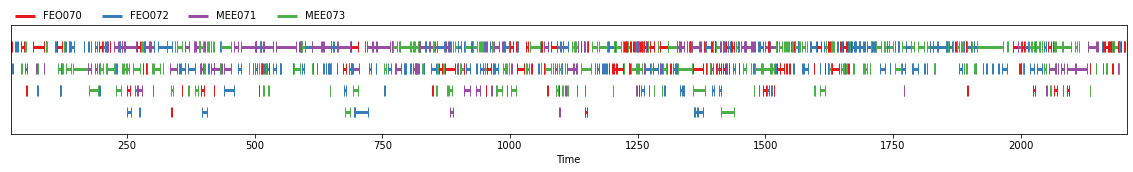

In [35]:
groundtruth # to see the labels of each speaker and time intervals, this will show last one only

In [ ]:
# print generated rttm of last test file
!cat {output_dir}/pred_rttms/TS3003d.Mix-Headset.rttm

pred_labels = rttm_to_labels(output_dir+'/pred_rttms/TS3003d.Mix-Headset.rttm')
hypothesis = labels_to_pyannote_object(pred_labels)
hypothesis

In [ ]:
# use spyder

hypothesis_rttm_list = []
hypothesis_rttm_filepath= os.path.join(output_dir, 'pred_rttms')

if test_type == 'test':
    hypothesis_rttm_list = glob.glob(hypothesis_rttm_filepath + '/*.rttm', recursive=True)
    
    for ground_rttm, hyp_rttm in zip(groundtruth_rttm_list, hypothesis_rttm_list):
        print("g h", ground_rttm)
        !spyder {ground_rttm} {hyp_rttm} --per-file

# der2 = abs(metric)

der = metric(groundtruth, hypothesis)
print(f'diarization error rate = {100 * der:.1f}%')